In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.proteoscopemodule import ProteoscopeLightningModule
import numpy as np
from omegaconf import OmegaConf


BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/15-38-19" # un-conditioned - looks good
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/17-33-19" # one-hot - looks good
BASE_DIR = "/home/ec2-user/outputs-proteoscope/proteoscope/2023-08-10/16-11-37" # mean
BASE_DIR = "/home/ec2-user/outputs-proteoscope/proteoscope/2023-08-12/05-49-10" # mean
BASE_DIR = "/home/ec2-user/outputs-proteoscope/proteoscope/2023-08-12/22-41-32" # mean
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/16-34-38" # 25 x 25 cond latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/22-36-50" # 25 x 25 cond nuclei + latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-05/01-50-26" # 25 x 25 cond nuclei + latent

config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim,
        sequence_embedding=config.data.sequence_embedding
    )
    pdm.setup()

    plm = ProteoscopeLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        unet_number=1,
    )

    plm.unet.eval()
    plm.unet.cuda()
    plm.autoencoder.cuda()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/tmp/ipykernel_5975/58342047.py:20: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/proteoscope/2023-08-12/22-41-32/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/datamodule.py:40: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)


## Generate samples

In [3]:
# pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=False, shuffle=True)
# dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [4]:
# # pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
# pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels[pdm.val_proteins_dataset.labels['localization'] != '']
# dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [5]:
# pdm.train_dataset.labels = pdm.train_dataset.labels.drop_duplicates(subset='ensg')
# dl = pdm.train_dataloader()

In [6]:
from tqdm import tqdm
import torch

true_images = []
true_localizations = []
predicted_images = []
predicted_latents = []
true_latents = []
true_names = []

# batch = next(iter(dl))
# cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()
for _ in range(1):
    for batch in tqdm(dl):
        batch['image'] = batch['image'].cuda()

        predicted_latent = plm.sample(batch, guidance_scale=3, cond_images=None)
        predicted_image = plm.autoencoder.decode(predicted_latent).sample
        true_latent = plm.autoencoder.encode(batch['image']).latent_dist.mean
        
        true_localizations.append(np.array(batch['localization']))

        true_images.append(batch['image'].detach().cpu().numpy())
        true_latents.append(true_latent.detach().cpu().numpy())
        predicted_latents.append(predicted_latent.detach().cpu().numpy())
        predicted_images.append(predicted_image.detach().cpu().numpy())
        true_names.append(batch['name'])

predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)
true_names = np.concatenate(true_names, axis=0)

  0%|          | 0/2870 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 1/2870 [00:32<26:00:11, 32.63s/it]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 2/2870 [00:56<21:58:33, 27.58s/it]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 3/2870 [01:20<20:42:43, 26.01s/it]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 4/2870 [01:45<20:08:59, 25.31s/it]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 5/2870 [02:09<19:52:08, 24.97s/it]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 6/2870 [02:33<19:41:15, 24.75s/it]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 7/2870 [02:58<19:34:22, 24.61s/it]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 7/2870 [02:58<20:18:51, 25.54s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14 │   for batch in tqdm(dl):                                                                  │
│   15 │   │   batch['image'] = batch['image'].cuda()                                              │
│   16 │   │                                                                                       │
│ ❱ 17 │   │   predicted_latent = plm.sample(batch, guidance_scale=3, cond_images=None)            │
│   18 │   │   predicted_image = plm.autoencoder.decode(predicted_latent).sample                   │
│   19 │   │   true_latent = plm.autoencoder.encode(batch['image']).latent_dist.mean               │
│   20                                                                                             │
│                                                                                                  │
│ /home/ec2-user/proteoscope/proteoscope/proteoscopemodule.py:212 in sample                        │
│                                                                                                  │
│   209 │   │   │                                                                                  │
│   210 │   │   │   # predict the noise residual                                                   │
│   211 │   │   │   with torch.no_grad():                                                          │
│ ❱ 212 │   │   │   │   noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=seq_   │
│   213 │   │   │                                                                                  │
│   214 │   │   │   # perform guidance                                                             │
│   215 │   │   │   noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)                       │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1190 in           │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1187 │   │   # this function, and just call forward.                                           │
│   1188 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1189 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1190 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1191 │   │   # Do not call functions when jit is used                                          │
│   1192 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1193 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/diffusers/models/unet_2d_condition.py:905 in │
│ forward                                                                                          │
│                                                                                                  │
│   902 │   │   down_block_res_samples = (sample,)                                                 │
│   903 │   │   for downsample_block in self.down_blocks:                                          │
│   904 │   │   │   if hasattr(downsample_block, "has_cross_attention") and downsample_block.has   │
│ ❱ 905 │   │   │   │   sample, res_samples = downsample_block(                                    │
│   906 │   │   │   │   │   hidden_states=sample,            

In [7]:
predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)
true_names = np.concatenate(true_names, axis=0)

In [8]:
true_names_avg = np.unique(true_names)
predicted_latents_avg = []
true_latents_avg = []

for name in true_names_avg:
    keep = true_names == name
    predicted_latents_avg.append(np.median(predicted_latents[keep], axis=0))
    true_latents_avg.append(np.median(true_latents[keep], axis=0))
predicted_latents_avg = np.array(predicted_latents_avg)
true_latents_avg = np.array(true_latents_avg)

In [9]:
# print(predicted_images.shape)
print(predicted_latents.shape)

(224, 16, 12, 12)


In [10]:
from proteoscope.plotting import browse_reconstructions, merge_prot_nuc


browse_reconstructions(true_images[:, 0], predicted_images[:, 0], true_names)

interactive(children=(Dropdown(description='name', options=('ACTG1', 'ACTN1', 'ACTN4', 'ACTR2', 'AGAP3', 'AKAP…

In [11]:
true_merged = merge_prot_nuc(true_images[:1000], percentiles=[0.1, 99.9])
predicted_merged = merge_prot_nuc(predicted_images[:1000], percentiles=[0.1, 99.9])
true_names_merged = true_names[:1000]

In [12]:
browse_reconstructions(true_merged, predicted_merged, true_names_merged)

interactive(children=(Dropdown(description='name', options=('ACTG1', 'ACTN1', 'ACTN4', 'ACTR2', 'AGAP3', 'AKAP…

## Cluster scores

In [13]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Generate sample data
n = len(true_names_avg)
Set_A = predicted_latents_avg.reshape(n, -1).copy()
Set_B = true_latents_avg.reshape(n, -1).copy()

# Compute pairwise distances for given pairs
given_pair_dists = np.array([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Compute pairwise distances for random pairs (1000 times)
random_pair_dists = []
np.random.seed(0)
for _ in range(1000):
    np.random.shuffle(Set_B)
    random_pair_dists.extend([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

P-value: 4.664245995824613e-121


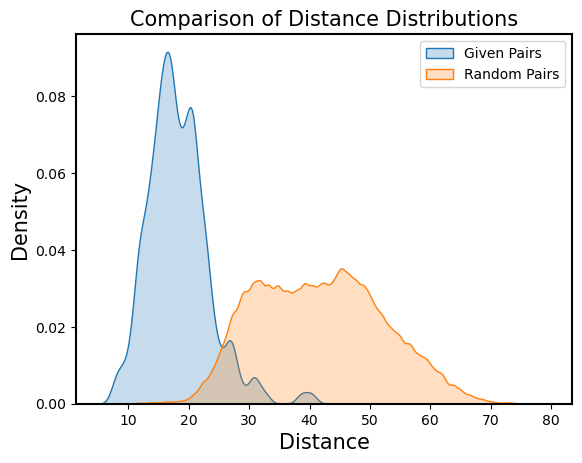

In [14]:
# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

## Umap

In [16]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/autoencoder-data/"
zarr_path = join(datapath, "full_embeddings_2.zarr")

z = zarr.open(zarr_path, mode="r")

In [18]:
labels = pdm.val_images_dataset.labels
latents = z.get_orthogonal_selection(list(labels.index))
latents = latents.reshape(latents.shape[0], -1)

In [27]:
print(latents.max())
print(latents.min())
print(predicted_latents.max())
print(predicted_latents.min())

10.501887321472168
-7.183016777038574
7.743128
-5.216063


In [19]:
from joblib import load

reducer = load(join(datapath,'umap_model_2a.joblib'))

In [20]:
reduced_latent = reducer.transform(latents)

In [21]:
import seaborn as sns

label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

In [22]:
localizations = np.array(labels['localization'])
localizations[localizations == ''] = 'other'

<AxesSubplot:>

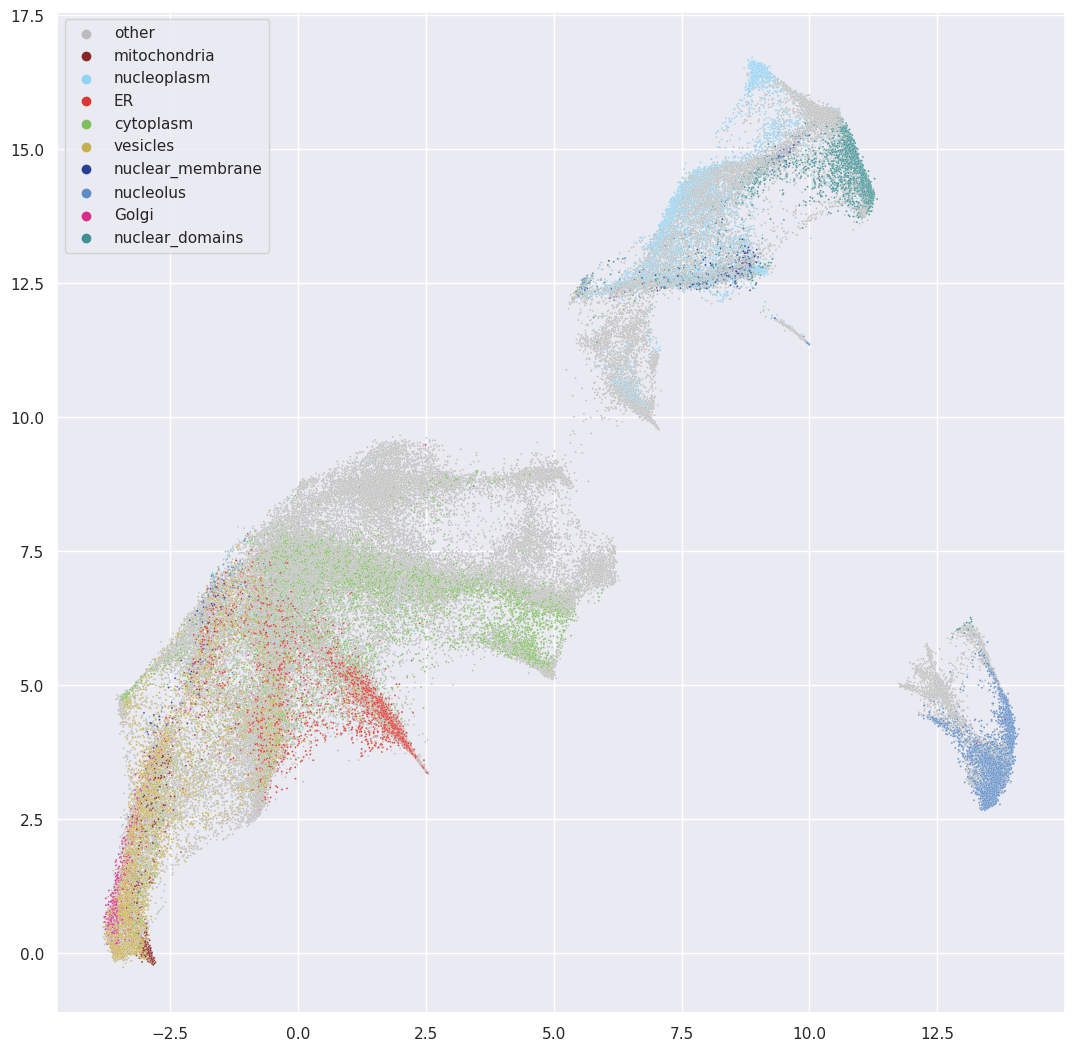

In [23]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_latent[:, 0], y=reduced_latent[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

In [24]:
predicted_latents = predicted_latents.reshape(predicted_latents.shape[0], -1)

In [25]:
reduced_outputs = reducer.transform(predicted_latents)
reduced_locs = true_localizations
reduced_locs[reduced_locs == ''] = 'other'

<AxesSubplot:>

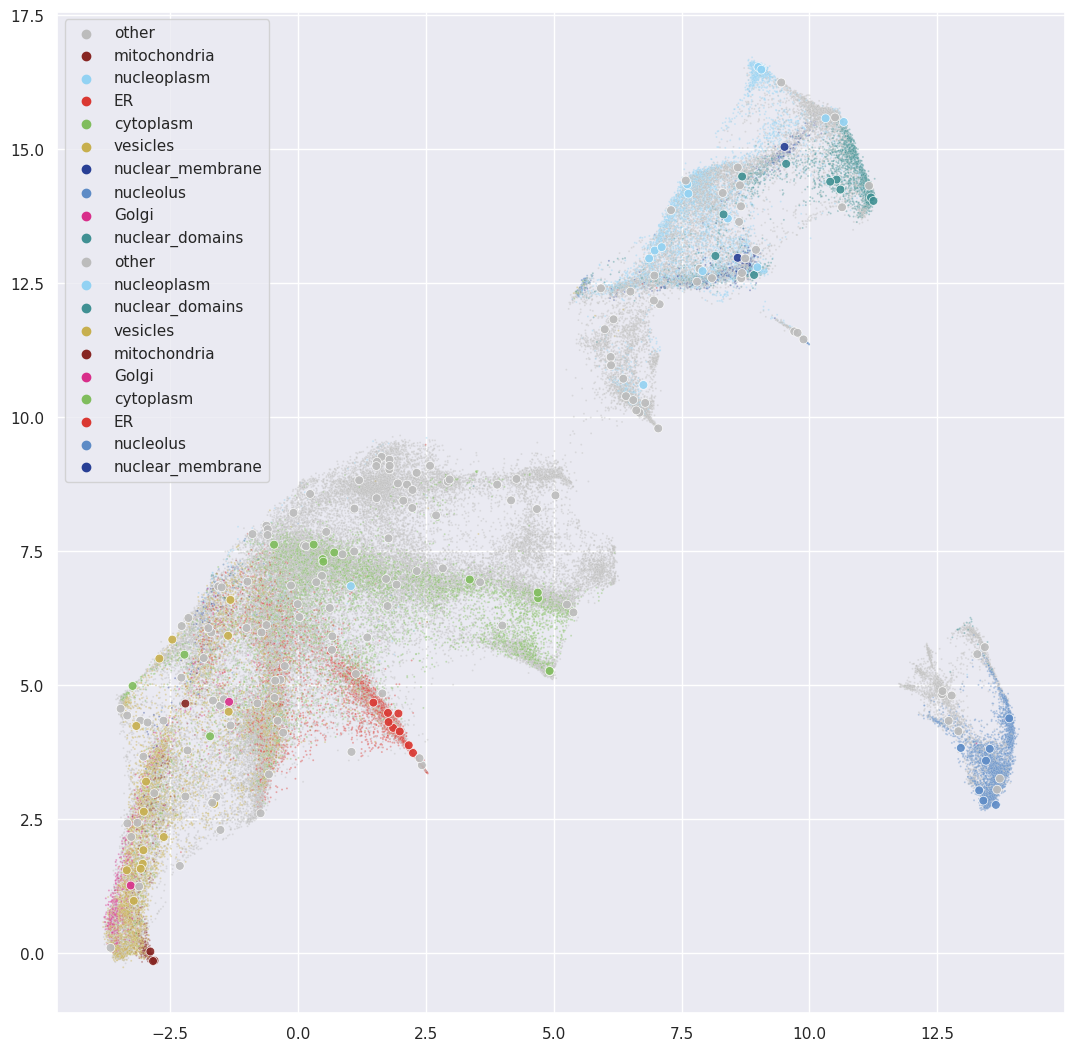

In [26]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_latent[:, 0], y=reduced_latent[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [28]:
true_latents = true_latents.reshape(true_latents.shape[0], -1)
reduced_true_outputs = reducer.transform(true_latents)

<AxesSubplot:>

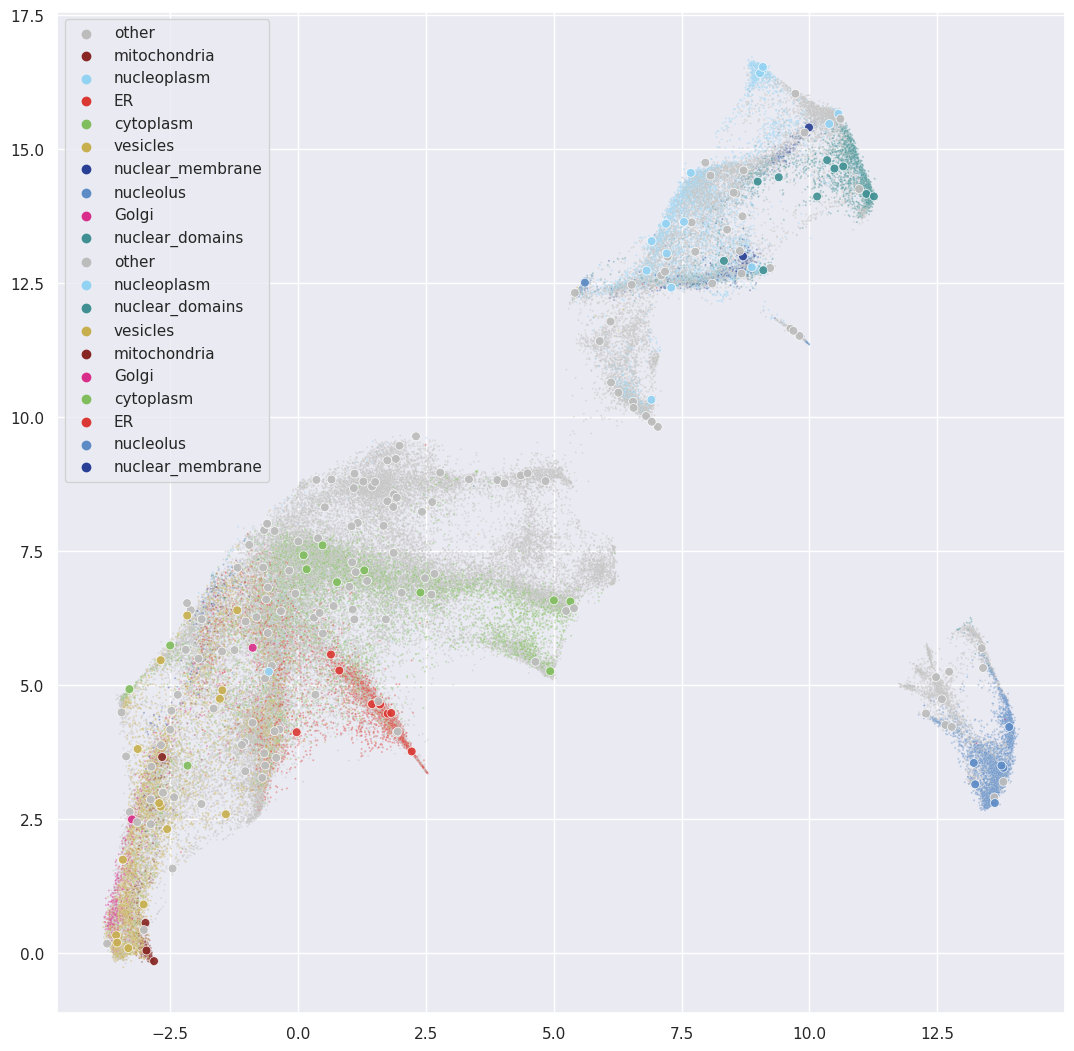

In [30]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_latent[:, 0], y=reduced_latent[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_true_outputs[:, 0], y=reduced_true_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

### Classifications

In [31]:
from joblib import load

# Load the model from the file
clf = load(join(datapath,'localization_classifier_2a.joblib'))


In [38]:
other = true_localizations == 'other'
X_test = predicted_latents[~other]
X_test = true_latents[~other]
y_test = true_localizations[~other]

In [39]:
true_latents.shape

(224, 2304)

In [40]:
y_predict = clf.predict(X_test)

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

# class_labels = np.unique(localizations[localizations != 'other'])
class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.8666666666666667


In [42]:
import matplotlib.pyplot as plt

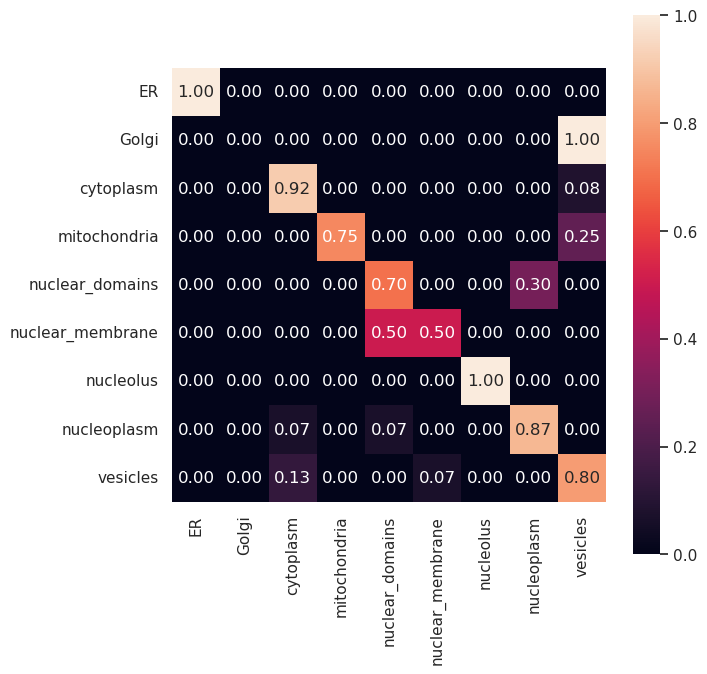

In [37]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

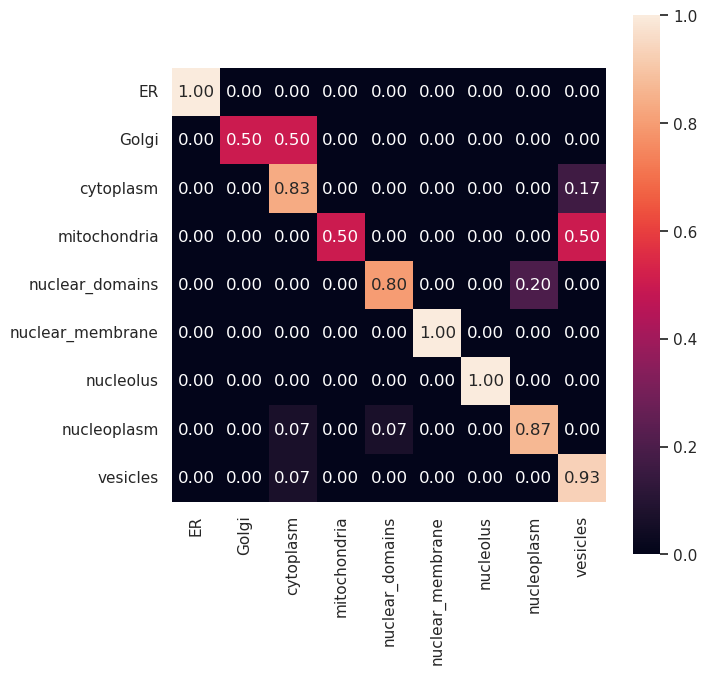

In [43]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Average latent space!

In [44]:
np.unique(names)

array(['AAMP', 'AATF', 'ABCE1', ..., 'ZCCHC9', 'ZNF326', 'ZYX'],
      dtype='<U9')

In [45]:
name = 'ZCCHC9'

In [46]:
med_e = np.median(embeddings[names == name], axis=0)

In [47]:
input = torch.from_numpy(med_e).unsqueeze_(0).float().cuda()

In [48]:
predicted_image = plm.autoencoder.decode(input).sample

In [49]:
predicted_image = predicted_image.detach().cpu().numpy()

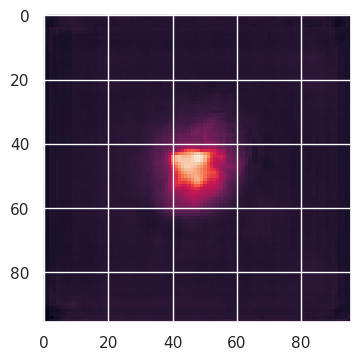

In [50]:
plt.figure(figsize=(4, 4))
plt.imshow(predicted_image[0, 0])

## Latent space position

In [51]:
full_embeddings = np.concatenate([embeddings_train_avg, true_latents_avg])
full_names = np.concatenate([names_train_avg, true_names_avg])

In [52]:
from annoy import AnnoyIndex

f = full_embeddings[0].size  # dimension of the vector
index = AnnoyIndex(f, metric='euclidean')

# Build the index with vectors from A
for i, v in enumerate(full_embeddings.reshape(full_embeddings.shape[0], -1)):
    index.add_item(i, v)
index.build(100)  # 10 trees, can be adjusted based on precision requirements

True

In [53]:
k = 1000
indices_list = []
for v in predicted_latents_avg:
    closest_indices = index.get_nns_by_vector(v.reshape(-1), k)
    indices_list.append(closest_indices)
indices_list = np.array(indices_list)

In [54]:
closest_names = full_names[indices_list]
matches = closest_names == true_names_avg[:, np.newaxis]

In [55]:
matches[:, 0].mean()

0.007633587786259542

In [56]:
scores = []
for j in range(1, matches.shape[1]):
    scores.append(matches[:, :j].any(axis=1).mean())

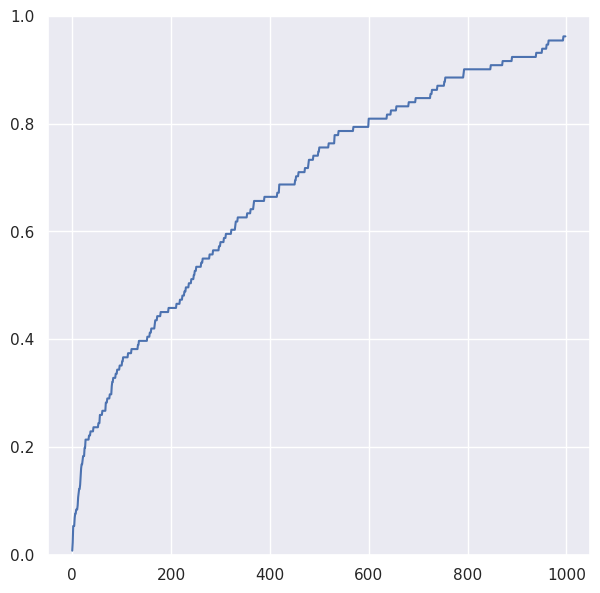

In [57]:
plt.figure(figsize=(7, 7))
plt.plot(scores);
plt.ylim([0, 1]);

In [58]:
old_scores = np.load('1000_full_aa_scores.npy')

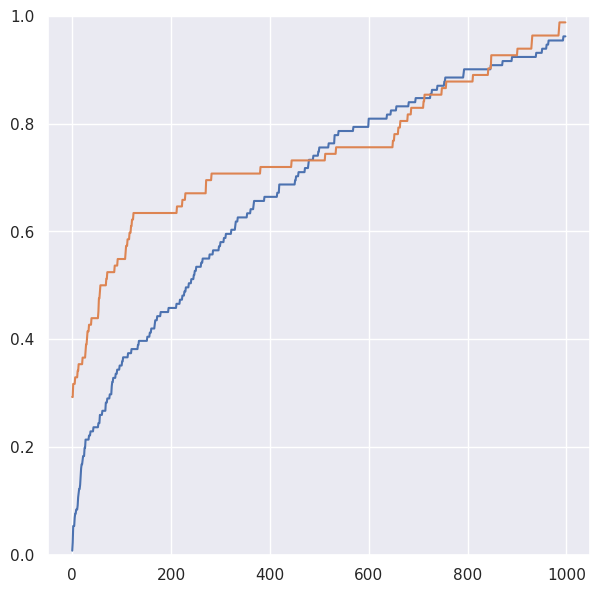

In [59]:
plt.figure(figsize=(7, 7))
plt.plot(scores);
plt.plot(old_scores);
plt.ylim([0, 1]);

In [95]:
# np.save('1000_full_aa_scores.npy', scores)

: 

## ESM localization baseline

In [64]:
pdm.train_dataset.labels = pdm.train_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.train_dataloader()


In [68]:
pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=True, shuffle=False)

In [69]:
from tqdm import tqdm
import torch

sequence_embeddings = []
true_localizations = []
for batch in tqdm(dl):    
    true_localizations.append(np.array(batch['localization']))
    sequence_embeddings.append(batch['sequence_embed'].detach().cpu().numpy())

true_localizations = np.concatenate(true_localizations, axis=0)
sequence_embeddings = np.concatenate(sequence_embeddings, axis=0)

100%|██████████| 5/5 [00:00<00:00,  6.03it/s]


In [67]:
embeddings_train = sequence_embeddings[:, 0, :]
localizations_train = true_localizations

In [70]:
embeddings = sequence_embeddings[:, 0, :]
localizations = true_localizations

In [73]:
from sklearn.linear_model import LogisticRegression

other = localizations_train == ''
X_train = embeddings_train[~other]
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = localizations_train[~other]

other = localizations == ''
X_test = embeddings[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = localizations[~other]

In [83]:
np.unique(y_test)

array(['ER', 'cytoplasm', 'nuclear_domains', 'nuclear_membrane',
       'nucleolus', 'nucleoplasm', 'vesicles'], dtype='<U16')

In [78]:
clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
from joblib import load
from joblib import dump

# Save the model to a file
dump(clf, join(datapath,'localization_classifier_esm.joblib'))

# # Load the model from the file
# clf = load(join(datapath,'localization_classifier_esm.joblib'))


['/home/ec2-user/autoencoder-data/localization_classifier_esm.joblib']

In [80]:
y_predict = clf.predict(X_test)

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.5111111111111111


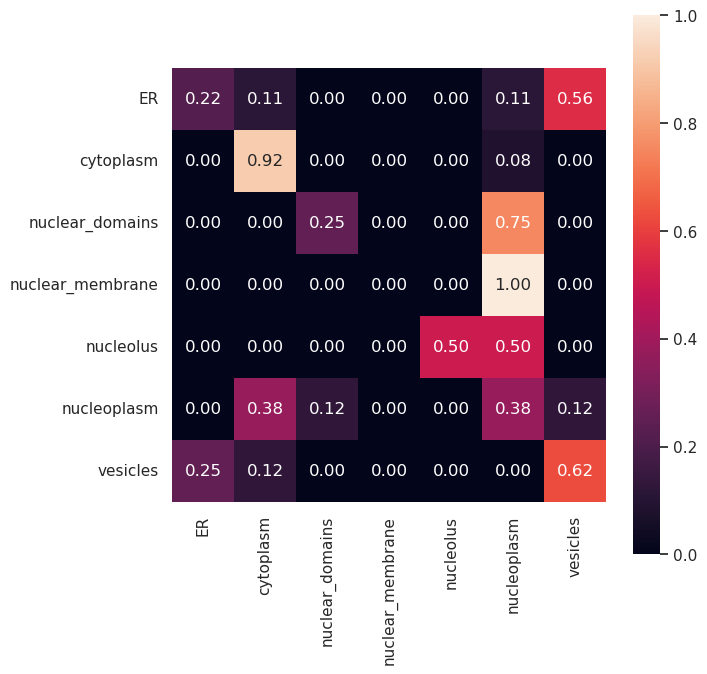

: 

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Combined classification